In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import env
#functions
import wrangle as wr
import explore as exp



warnings.filterwarnings("ignore")

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# from our acquire.py:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

In [5]:
df = get_zillow_data()

In [6]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,NaN,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,NaN,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,NaN,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,NaN,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,NaN,...,6.037461e+13,-0.001011,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


(-1.0, 1.0)

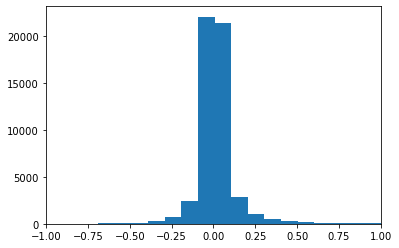

In [7]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=100)
plt.xlim(-1, 1)

In [8]:
#remove columns
def remove_columns(df, cols_to_remove):
    df = df.drop(columns = cols_to_remove)
    return df

In [9]:
#handle missing values
def handle_missing_values(df, prop_required_columns =0.15, prop_required_row=0.15):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    #axis 1 : drop columns that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    #axis 0 : drop rows that have missing values
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [10]:
# combining everything in a cleaning function:
def data_prep(df, cols_to_remove=[], prop_required_column=0.85, prop_required_row=0.85):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [11]:
df = data_prep(df, cols_to_remove = ['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'architecturalstyledesc',
 'buildingclassdesc',
 'propertylandusedesc',
 'regionidneighborhood',                                   
 'storydesc',
 'typeconstructiondesc'], prop_required_column=0.15, prop_required_row=0.15)

In [12]:
df.columns.values.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc']

In [13]:
df = wr.clean_and_prep(df)

In [14]:
df.isna().sum(), df.shape

(parcelid                               0
 bathrooms                              0
 bedrooms                               0
 fips                                   0
 fullbathcnt                            0
 garagecarcnt                           0
 latitude                               0
 longitude                              0
 lotsizesquarefeet                      0
 poolcnt                                0
 regionidcity                           0
 regionidcounty                         0
 regionidzip                            0
 yearbuilt                              0
 structuretaxvaluedollarcnt             0
 home_value                             0
 landtaxvaluedollarcnt                  0
 taxamount                              0
 logerror                               0
 transactiondate                        0
 airconditioningdesc                    0
 heatingorsystemdesc                    0
 home_value_structure_tax_difference    0
 hvs_pct                          

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52156 entries, 0 to 52318
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   parcelid                             52156 non-null  int64  
 1   bathrooms                            52156 non-null  float64
 2   bedrooms                             52156 non-null  float64
 3   fips                                 52156 non-null  float64
 4   fullbathcnt                          52156 non-null  float64
 5   garagecarcnt                         52156 non-null  object 
 6   latitude                             52156 non-null  float64
 7   longitude                            52156 non-null  float64
 8   lotsizesquarefeet                    52156 non-null  float64
 9   poolcnt                              52156 non-null  object 
 10  regionidcity                         52156 non-null  float64
 11  regionidcounty              

In [18]:
df['quarter'] = pd.PeriodIndex(df.transactiondate, freq='Q')

In [19]:
train, validate, test = wr.split(df, stratify_by=None)

In [20]:
train.shape, validate.shape, test.shape

((29206, 26), (12518, 26), (10432, 26))

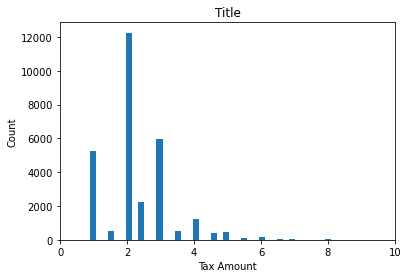

In [56]:
plt.hist(train.bathrooms, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,10])
plt.ylabel('Count')
plt.show()

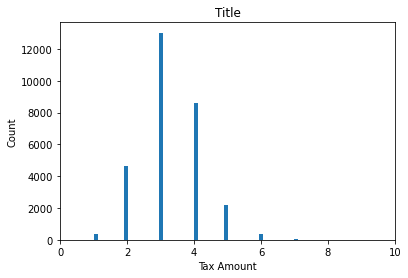

In [57]:
plt.hist(train.bedrooms, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,10])
plt.ylabel('Count')
plt.show()

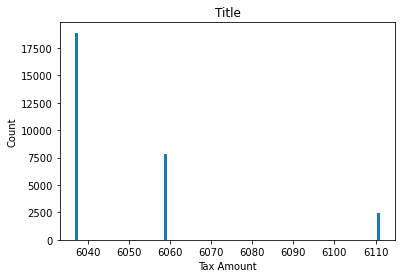

In [59]:
plt.hist(train.fips, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')

plt.ylabel('Count')
plt.show()

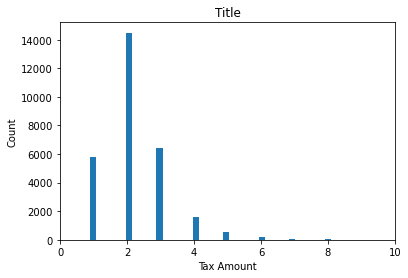

In [60]:
plt.hist(train.fullbathcnt, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,10])
plt.ylabel('Count')
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

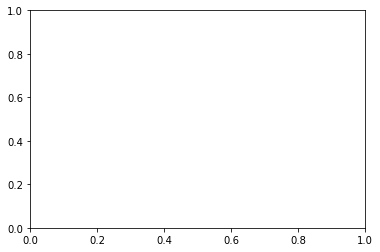

In [61]:
plt.hist(train.garagecarcnt, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,10])
plt.ylabel('Count')
plt.show()

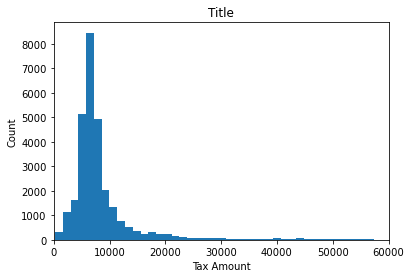

In [69]:
plt.hist(train.lotsizesquarefeet, bins=5000)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,60000])
plt.ylabel('Count')
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

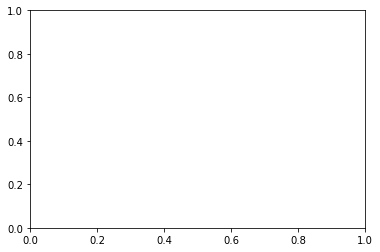

In [70]:
plt.hist(train.poolcnt, bins=100)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,10])
plt.ylabel('Count')
plt.show()

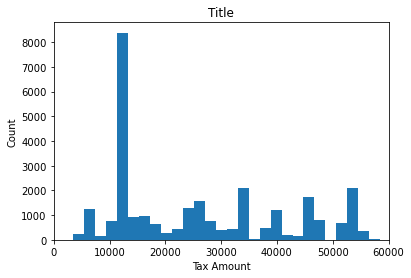

In [74]:
plt.hist(train.regionidcity, bins=200)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,60000])
plt.ylabel('Count')
plt.show()

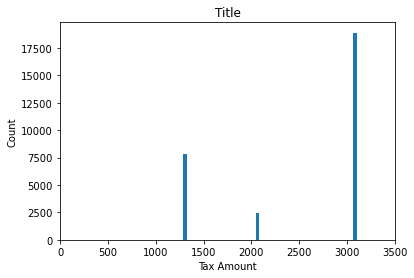

In [83]:
plt.hist(train.regionidcounty, bins=50)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,3500])
plt.ylabel('Count')
plt.show()

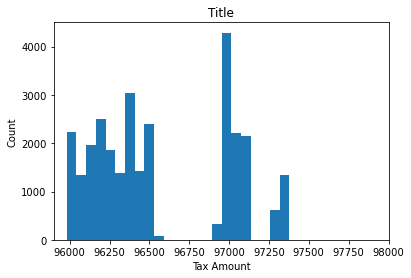

In [111]:
plt.hist(train.regionidzip, bins=5000)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([95900,98000])
plt.ylabel('Count')
plt.show()

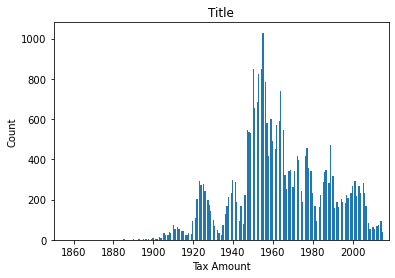

In [115]:
plt.hist(train.yearbuilt, bins=200)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([1850,2018])
plt.ylabel('Count')
plt.show()

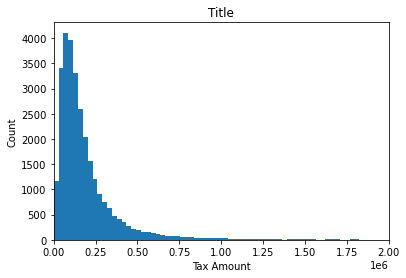

In [123]:
plt.hist(train.structuretaxvaluedollarcnt, bins=300)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,2000000])
plt.ylabel('Count')
plt.show()

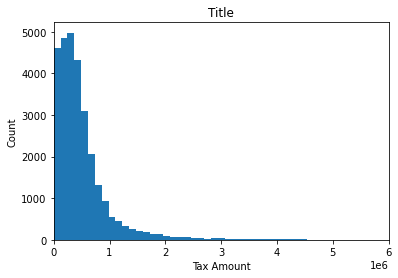

In [127]:
plt.hist(train.home_value, bins=400)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,6000000])
plt.ylabel('Count')
plt.show()

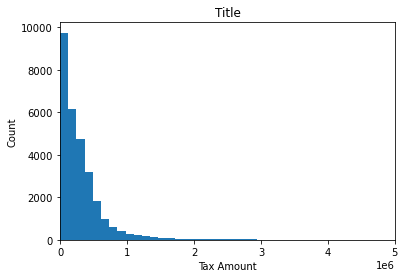

In [132]:
plt.hist(train.landtaxvaluedollarcnt, bins=400)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,5000000])
plt.ylabel('Count')
plt.show()

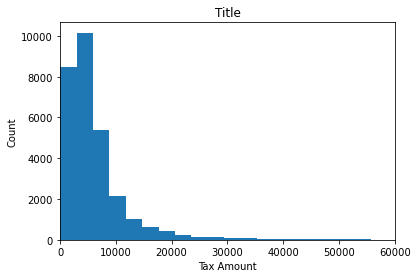

In [133]:
plt.hist(train.taxamount, bins=200)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,60000])
plt.ylabel('Count')
plt.show()

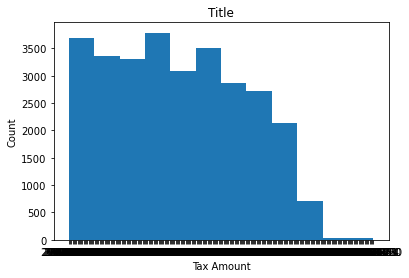

In [140]:
plt.hist(train.transactiondate, bins=12)

plt.title('Title')
plt.xlabel('Tax Amount')

plt.ylabel('Count')
plt.show()

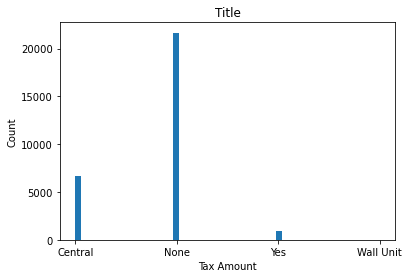

In [144]:
plt.hist(train.airconditioningdesc, bins=50)

plt.title('Title')
plt.xlabel('Tax Amount')

plt.ylabel('Count')
plt.show()

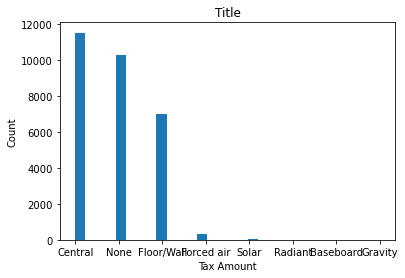

In [150]:
plt.hist(train.heatingorsystemdesc, bins=30)

plt.title('Title')
plt.xlabel('Tax Amount')

plt.ylabel('Count')
plt.show()

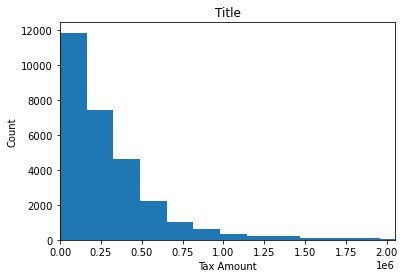

In [157]:
plt.hist(train.home_value_structure_tax_difference, bins=300)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,2050000])
plt.ylabel('Count')
plt.show()

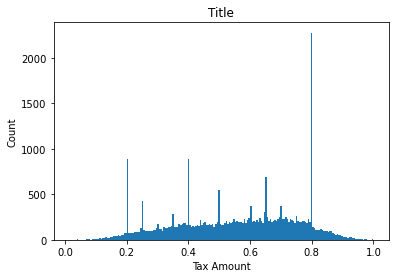

In [159]:
plt.hist(train.hvs_pct, bins=200)

plt.title('Title')
plt.xlabel('Tax Amount')

plt.ylabel('Count')
plt.show()

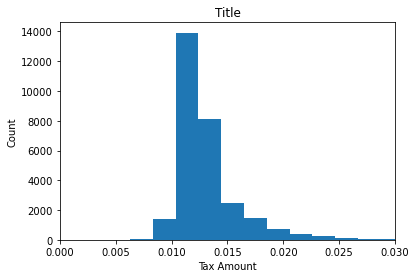

In [164]:
plt.hist(train.taxrate, bins=400)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,.03])
plt.ylabel('Count')
plt.show()

TypeError: '<' not supported between instances of 'Period' and 'float'

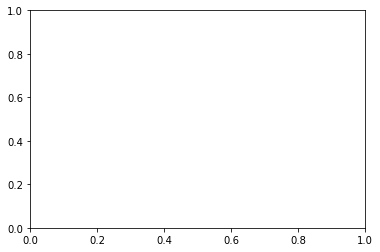

In [165]:
plt.hist(train.quarter, bins=200)

plt.title('Title')
plt.xlabel('Tax Amount')
plt.xlim([0,60000])
plt.ylabel('Count')
plt.show()

In [52]:
df.columns.values.tolist()

['parcelid',
 'bathrooms',
 'bedrooms',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'home_value',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc',
 'home_value_structure_tax_difference',
 'hvs_pct',
 'taxrate',
 'quarter']

## five questions
    1. more error based on location? county? coast? lat/long? fips?
    2. error related to cost?
    3. error related to lot size?
    4. error related to age?
    5. error related transaction date? seasonal?
    6. error related to luxury items, garage, pool, airconditioning?
    7. error related to tax/value/structure/land?

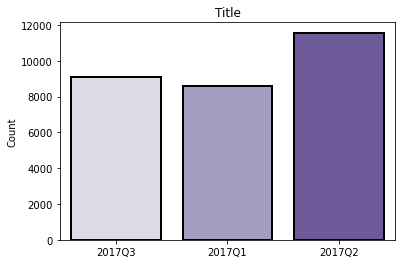

In [173]:
sns.countplot(x = 'quarter', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

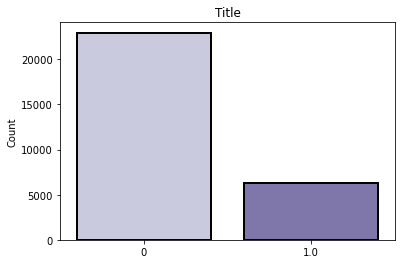

In [174]:
sns.countplot(x = 'poolcnt', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

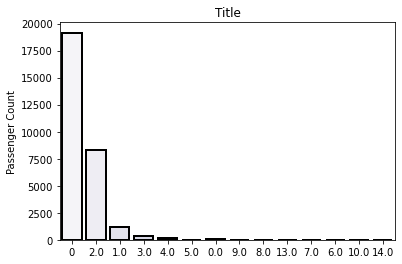

In [172]:
sns.countplot(x = 'garagecarcnt', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

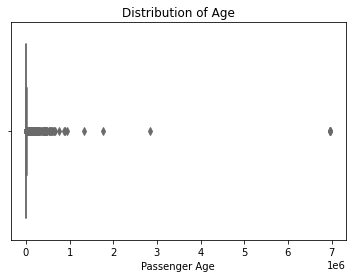

In [177]:
sns.boxplot(x=train.lotsizesquarefeet, palette='Purples')

plt.title('Distribution of Age')
plt.xlabel('Passenger Age')

plt.show()

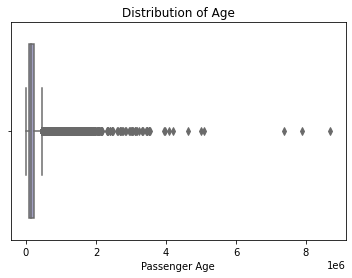

In [178]:
sns.boxplot(x=train.structuretaxvaluedollarcnt, palette='Purples')

plt.title('Distribution of Age')
plt.xlabel('Passenger Age')

plt.show()

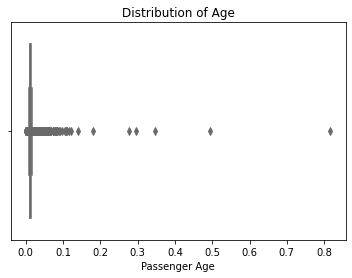

In [179]:
sns.boxplot(x=train.taxrate, palette='Purples')

plt.title('Distribution of Age')
plt.xlabel('Passenger Age')

plt.show()

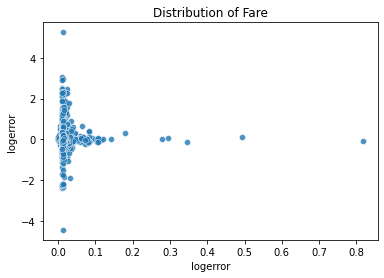

In [183]:
sns.scatterplot(train.taxrate, train.logerror, alpha=.8)

plt.title('Distribution of Fare')
plt.xlabel('logerror')
plt.ylabel('logerror')

plt.show()

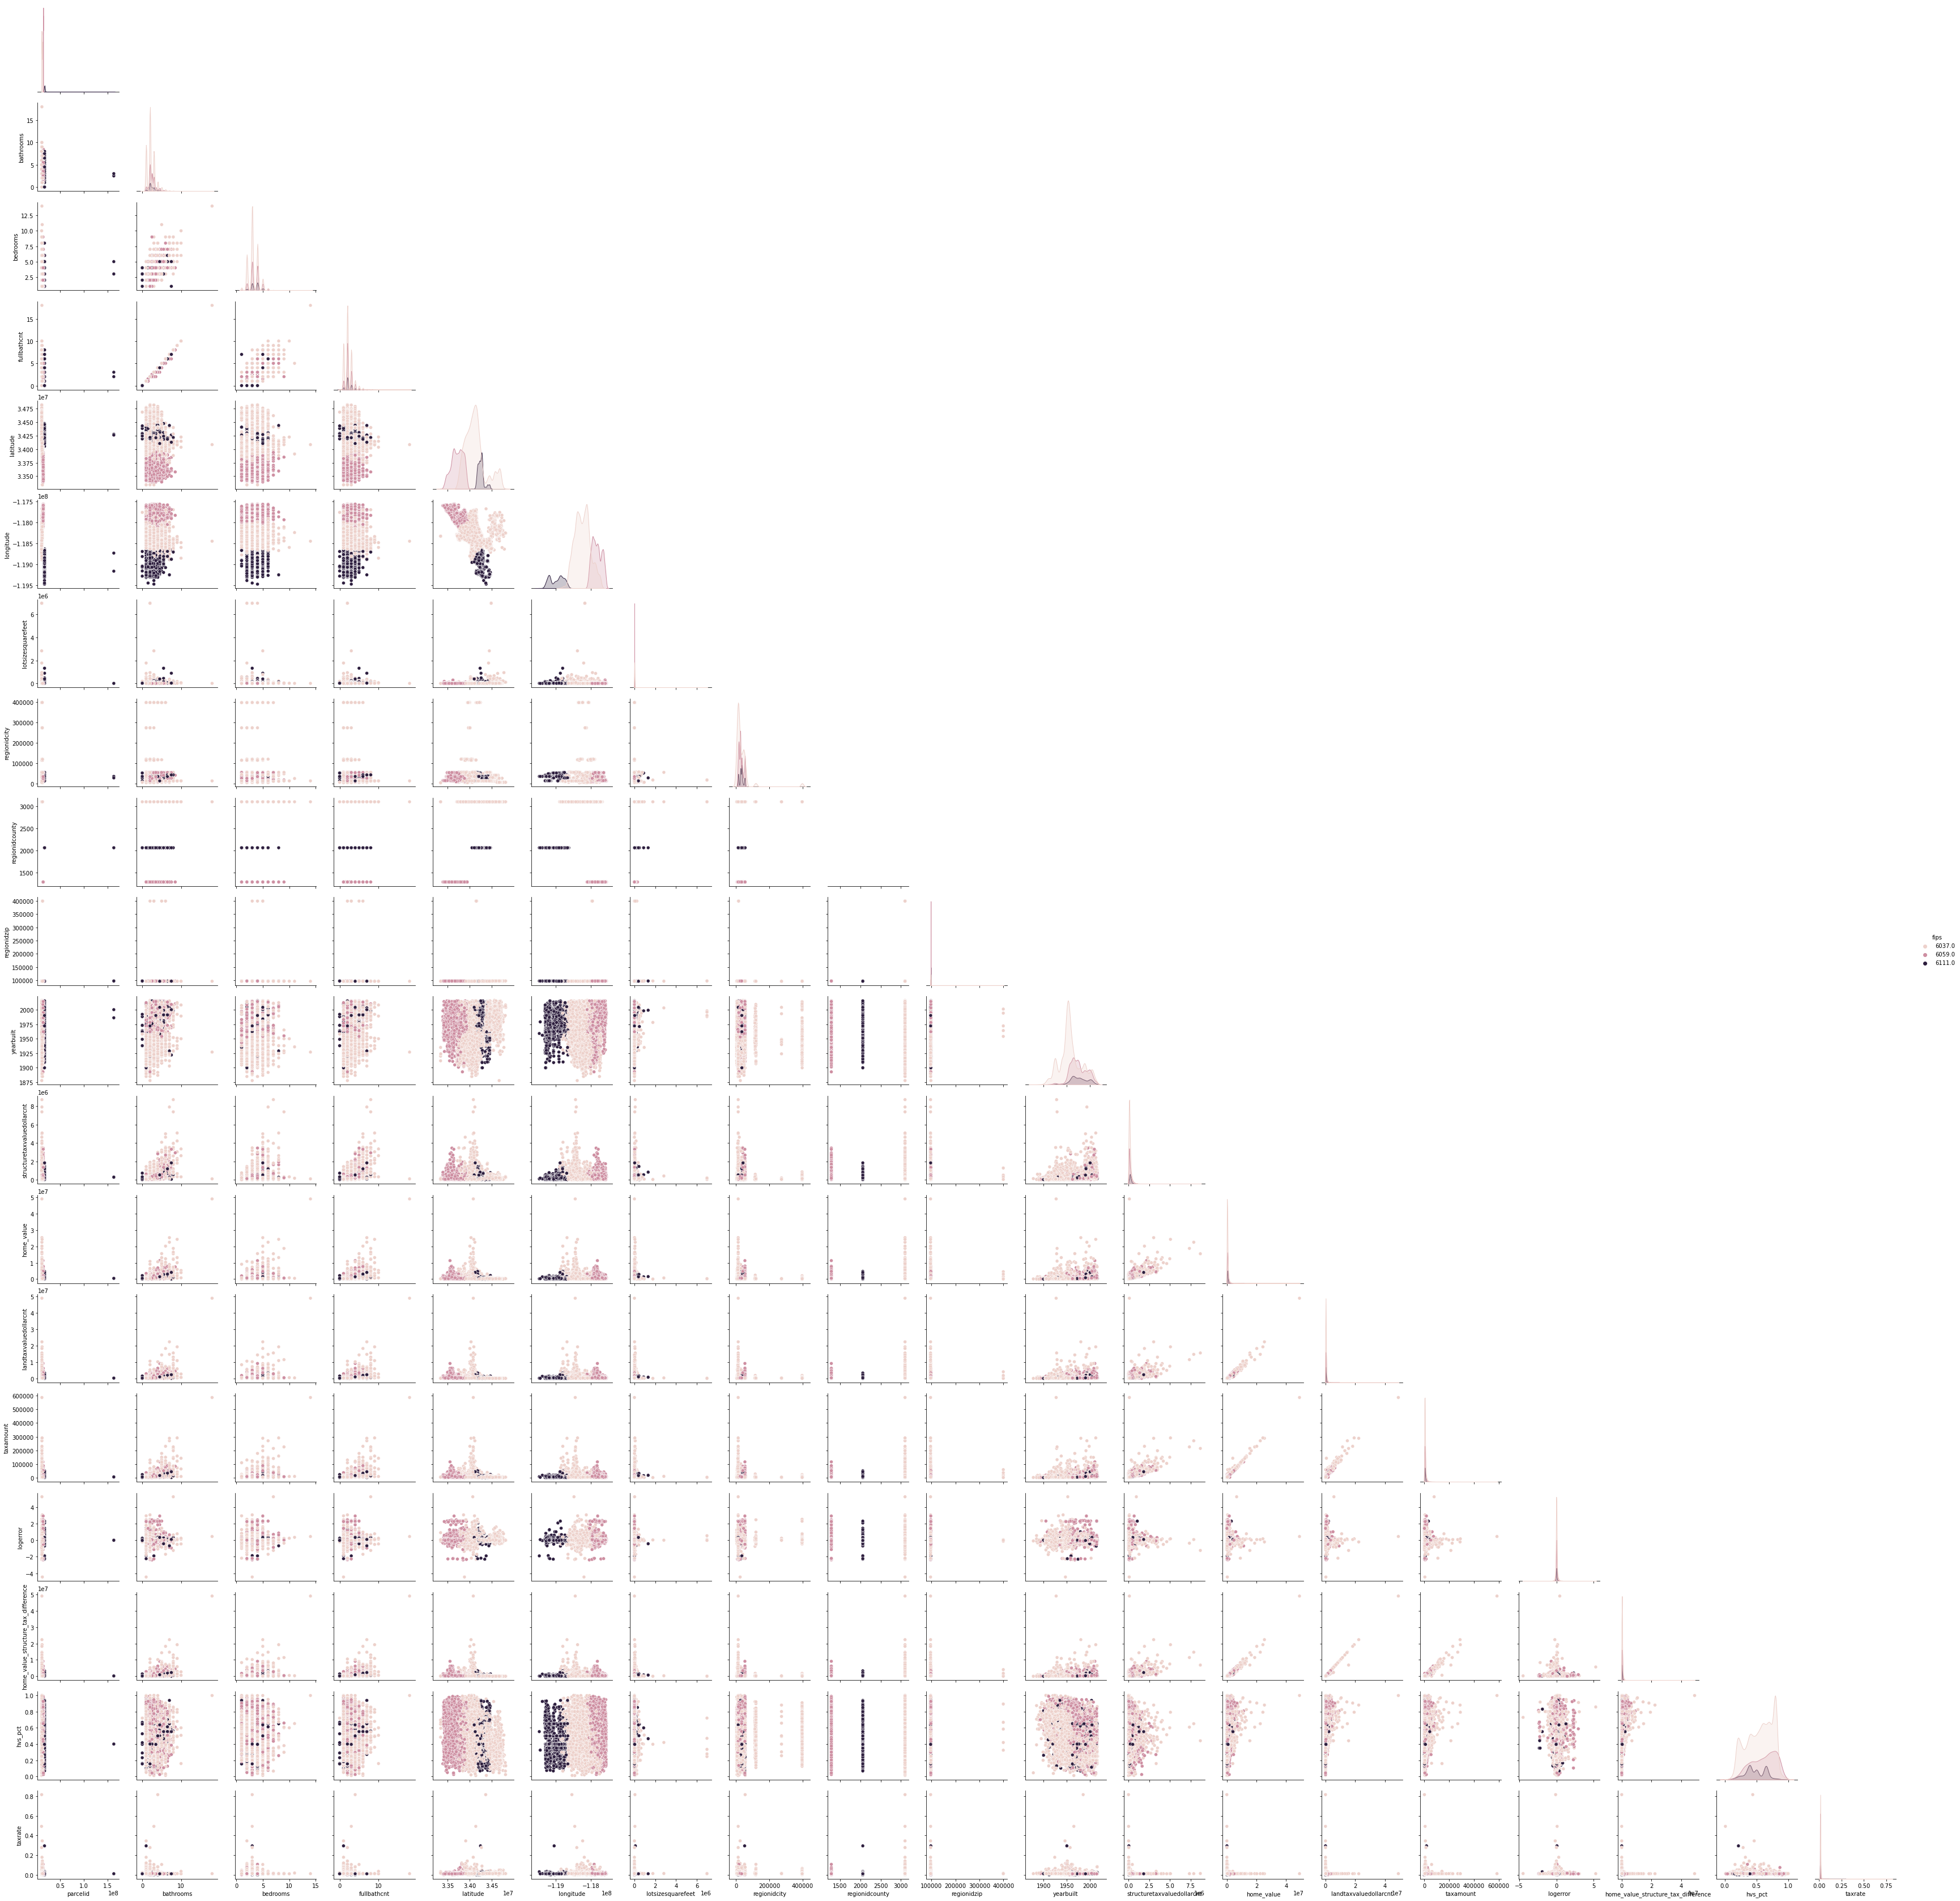

In [184]:
sns.pairplot(data=train, corner=True, hue='fips')

plt.show()

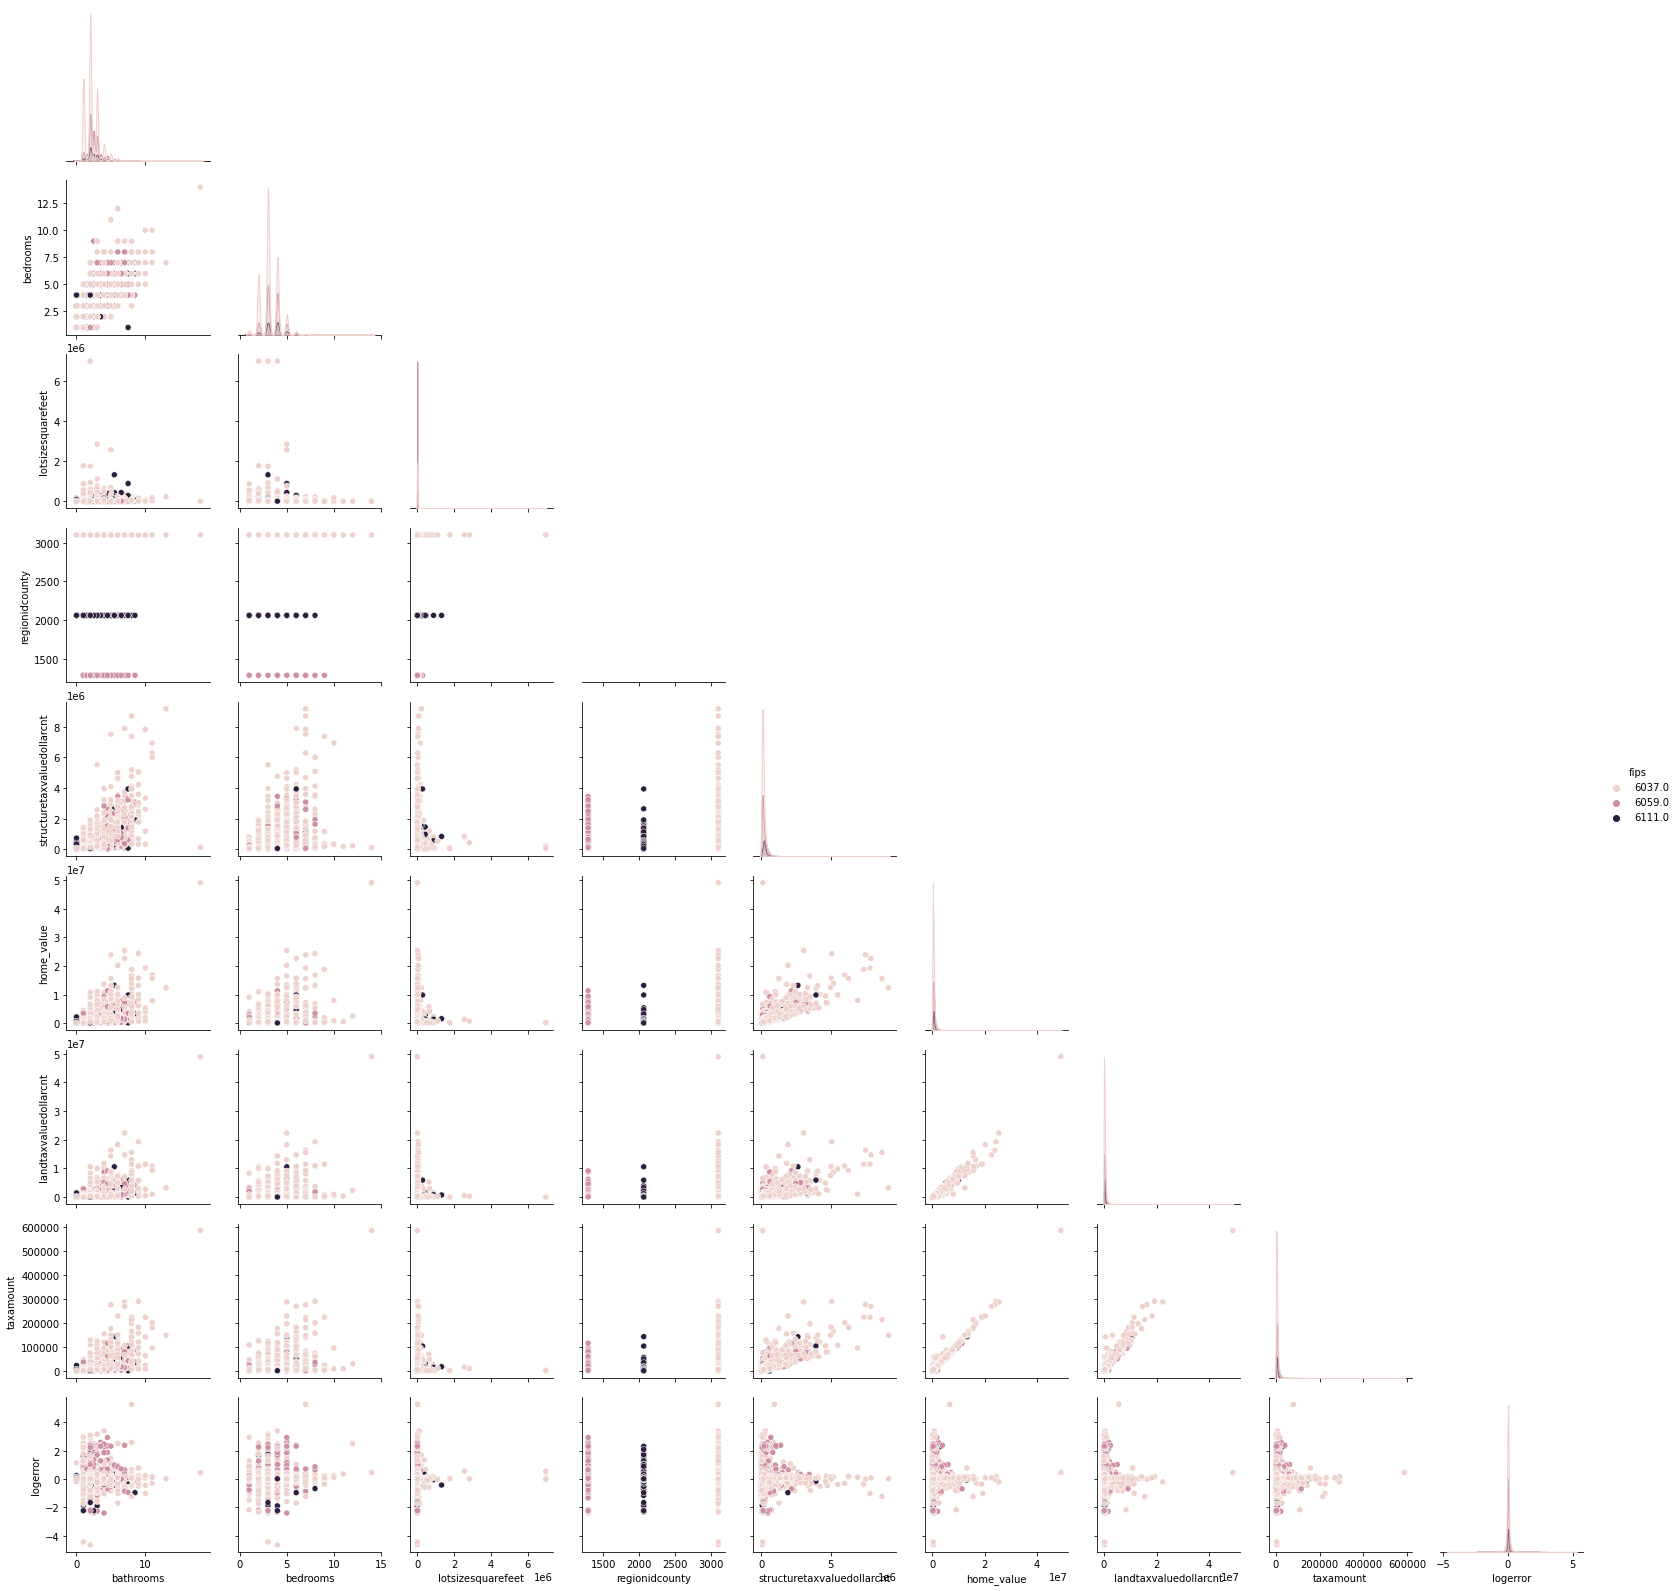

In [189]:
sns.pairplot(
    df,
    vars=['bathrooms',
 'bedrooms','lotsizesquarefeet',
 'regionidcounty','structuretaxvaluedollarcnt',
 'home_value',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',],
    corner=True, hue="fips"
)

In [185]:
df.columns.values.tolist()

['parcelid',
 'bathrooms',
 'bedrooms',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'home_value',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc',
 'home_value_structure_tax_difference',
 'hvs_pct',
 'taxrate',
 'quarter']

In [ ]:
plt.subplot(211)

sns.countplot(x = 'taxrate', hue = 'logerror', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does the Embark Town Relate to Passenger Survival Status?')
plt.xlabel('')
plt.ylabel('')

plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'hvs_pct', hue = 'logerror', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Did Not Survive', 'Survived'])

plt.show()